# What are the most effective marketing channels and campaigns?

## 1. Evaluate the ROI of different marketing channels

In [2]:
#Importing Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans

In [3]:
#Importing Data (Online Sales)
online_sales = pd.read_csv('../data/online_sales_edited.csv')
online_sales_users = pd.read_csv('../data/online_sales_users.csv')
discount_coupon = pd.read_csv('../data/source/Discount_Coupon.csv')


In [4]:
#Importing Data (Amazon)
daily_sales = pd.read_csv('../data/daily_sales.csv')
products = pd.read_csv('../data/products.csv')
ratings = pd.read_csv('../data/ratings.csv')

In [5]:
#Importing Data (Customer Behaviour)
user_behaviour = pd.read_csv('../data/user_behaviour.csv')
users = pd.read_csv('../data/users.csv')

### Analysis of ROI Across Different Product Category

In [6]:
# Merge online_sales with product data to get prices and category
sales_data = pd.merge(online_sales, products, on='product_id', how='left')
sales_data = pd.merge(sales_data, discount_coupon, how='left', on=['Coupon_Code'])
sales_data['date'] = pd.to_datetime(sales_data['date'])

# Inspect merged dataset
print(sales_data.head())

   user_id  transaction_id       date  product_id  Quantity  Delivery_Charges  \
0    17850           16679 2019-01-01  B09DL9978Y         1               6.5   
1    17850           16679 2019-01-01  B09DL9978Y         1               6.5   
2    17850           16679 2019-01-01  B09DL9978Y         1               6.5   
3    17850           16679 2019-01-01  B09DL9978Y         1               6.5   
4    17850           16680 2019-01-01  B09DL9978Y         1               6.5   

  Coupon_Status Coupon_Code  Discount_pct_x  \
0          Used      ELEC10             0.1   
1          Used      ELEC10             0.1   
2          Used      ELEC10             0.1   
3          Used      ELEC10             0.1   
4          Used      ELEC10             0.1   

                                        product_name  \
0  Hindware Atlantic Compacto 3 Litre Instant wat...   
1  Hindware Atlantic Compacto 3 Litre Instant wat...   
2  Hindware Atlantic Compacto 3 Litre Instant wat...   
3  Hin

Formulation

1. Revenue
Formula: revenue = quantity * actual_price
Explanation: Calculation of how much money was generated from sales. It multiplies the number of units sold (quantity) by the full price of the product (actual price), giving us the total revenue from sales before any discounts.
2. Discounted Revenue
Formula: discounted_revenue = quantity * discounted_price
Explanation: This represents the revenue generated from the sale after applying any discounts. It multiplies the number of units sold by the discounted price of the product. This gives a sense of the actual money collected from sales post-discount.
3. Discount Cost
Formula: discount_cost = quantity * (actual_price - discounted_price)
Explanation: The difference between the actual price and the discounted price represents the amount of money "lost" due to the discount, and it can be viewed as a marketing expense. When a product is discounted, it's essentially a form of marketing expenditure to entice customers to buy. Thus, the discount cost is calculated by multiplying the price difference by the number of units sold. This cost acts as a proxy for how much the company "spent" to attract customers through discounts. If the product were sold at full price, there would be no discount cost.
4. ROI
Formula: ROI = revenue / (discount_cost + 1)
Explanation: Typically, ROI measures the return generated on the money invested. In this case, we're treating the discount given as the "investment" (or cost) to generate revenue. Revenue is the "return" or gain. Discount Cost is treated as the "investment" or the marketing expenditure. The ROI formula includes +1 to avoiding division by zero, if a product was sold at full price (no discount), the discount_cost would be zero. In such cases, we don't want to divide by zero. The +1 prevents division by zero while keeping the calculation stable. It doesn't materially affect the outcome, as adding 1 to large values doesn't change the result significantly, but it ensures that we don't run into errors in cases of full-price sales. Hence, this proxy calculation for ROI is specifically focused on evaluating marketing effectiveness.

In [7]:
# Calculate revenue, discounted revenue, and marketing discount cost
sales_data['revenue'] = sales_data['Quantity'] * sales_data['actual_price']
sales_data['discounted_revenue'] = sales_data['Quantity'] * sales_data['discounted_price']
sales_data['discount_cost'] = sales_data['Quantity'] * (sales_data['actual_price'] - sales_data['discounted_price'])

# Calculate ROI (Revenue divided by Discount Cost + 1 to avoid division by zero)
sales_data['ROI'] = sales_data['revenue'] / (sales_data['discount_cost'] + 1)

# Preview the metrics
print(sales_data[['product_name', 'Quantity', 'revenue', 'discounted_revenue', 'discount_cost', 'ROI']].head())

                                        product_name  Quantity  revenue  \
0  Hindware Atlantic Compacto 3 Litre Instant wat...         1    55.08   
1  Hindware Atlantic Compacto 3 Litre Instant wat...         1    55.08   
2  Hindware Atlantic Compacto 3 Litre Instant wat...         1    55.08   
3  Hindware Atlantic Compacto 3 Litre Instant wat...         1    55.08   
4  Hindware Atlantic Compacto 3 Litre Instant wat...         1    55.08   

   discounted_revenue  discount_cost       ROI  
0               28.79          26.29  2.018322  
1               28.79          26.29  2.018322  
2               28.79          26.29  2.018322  
3               28.79          26.29  2.018322  
4               28.79          26.29  2.018322  


In [8]:
# Group data by month and category to get aggregated metrics
sales_by_month_category = sales_data.groupby([sales_data['date'].dt.to_period('M'), 'category']).agg({
    'revenue': 'sum',
    'discounted_revenue': 'sum',
    'discount_cost': 'sum',
    'ROI': 'mean'
}).reset_index()

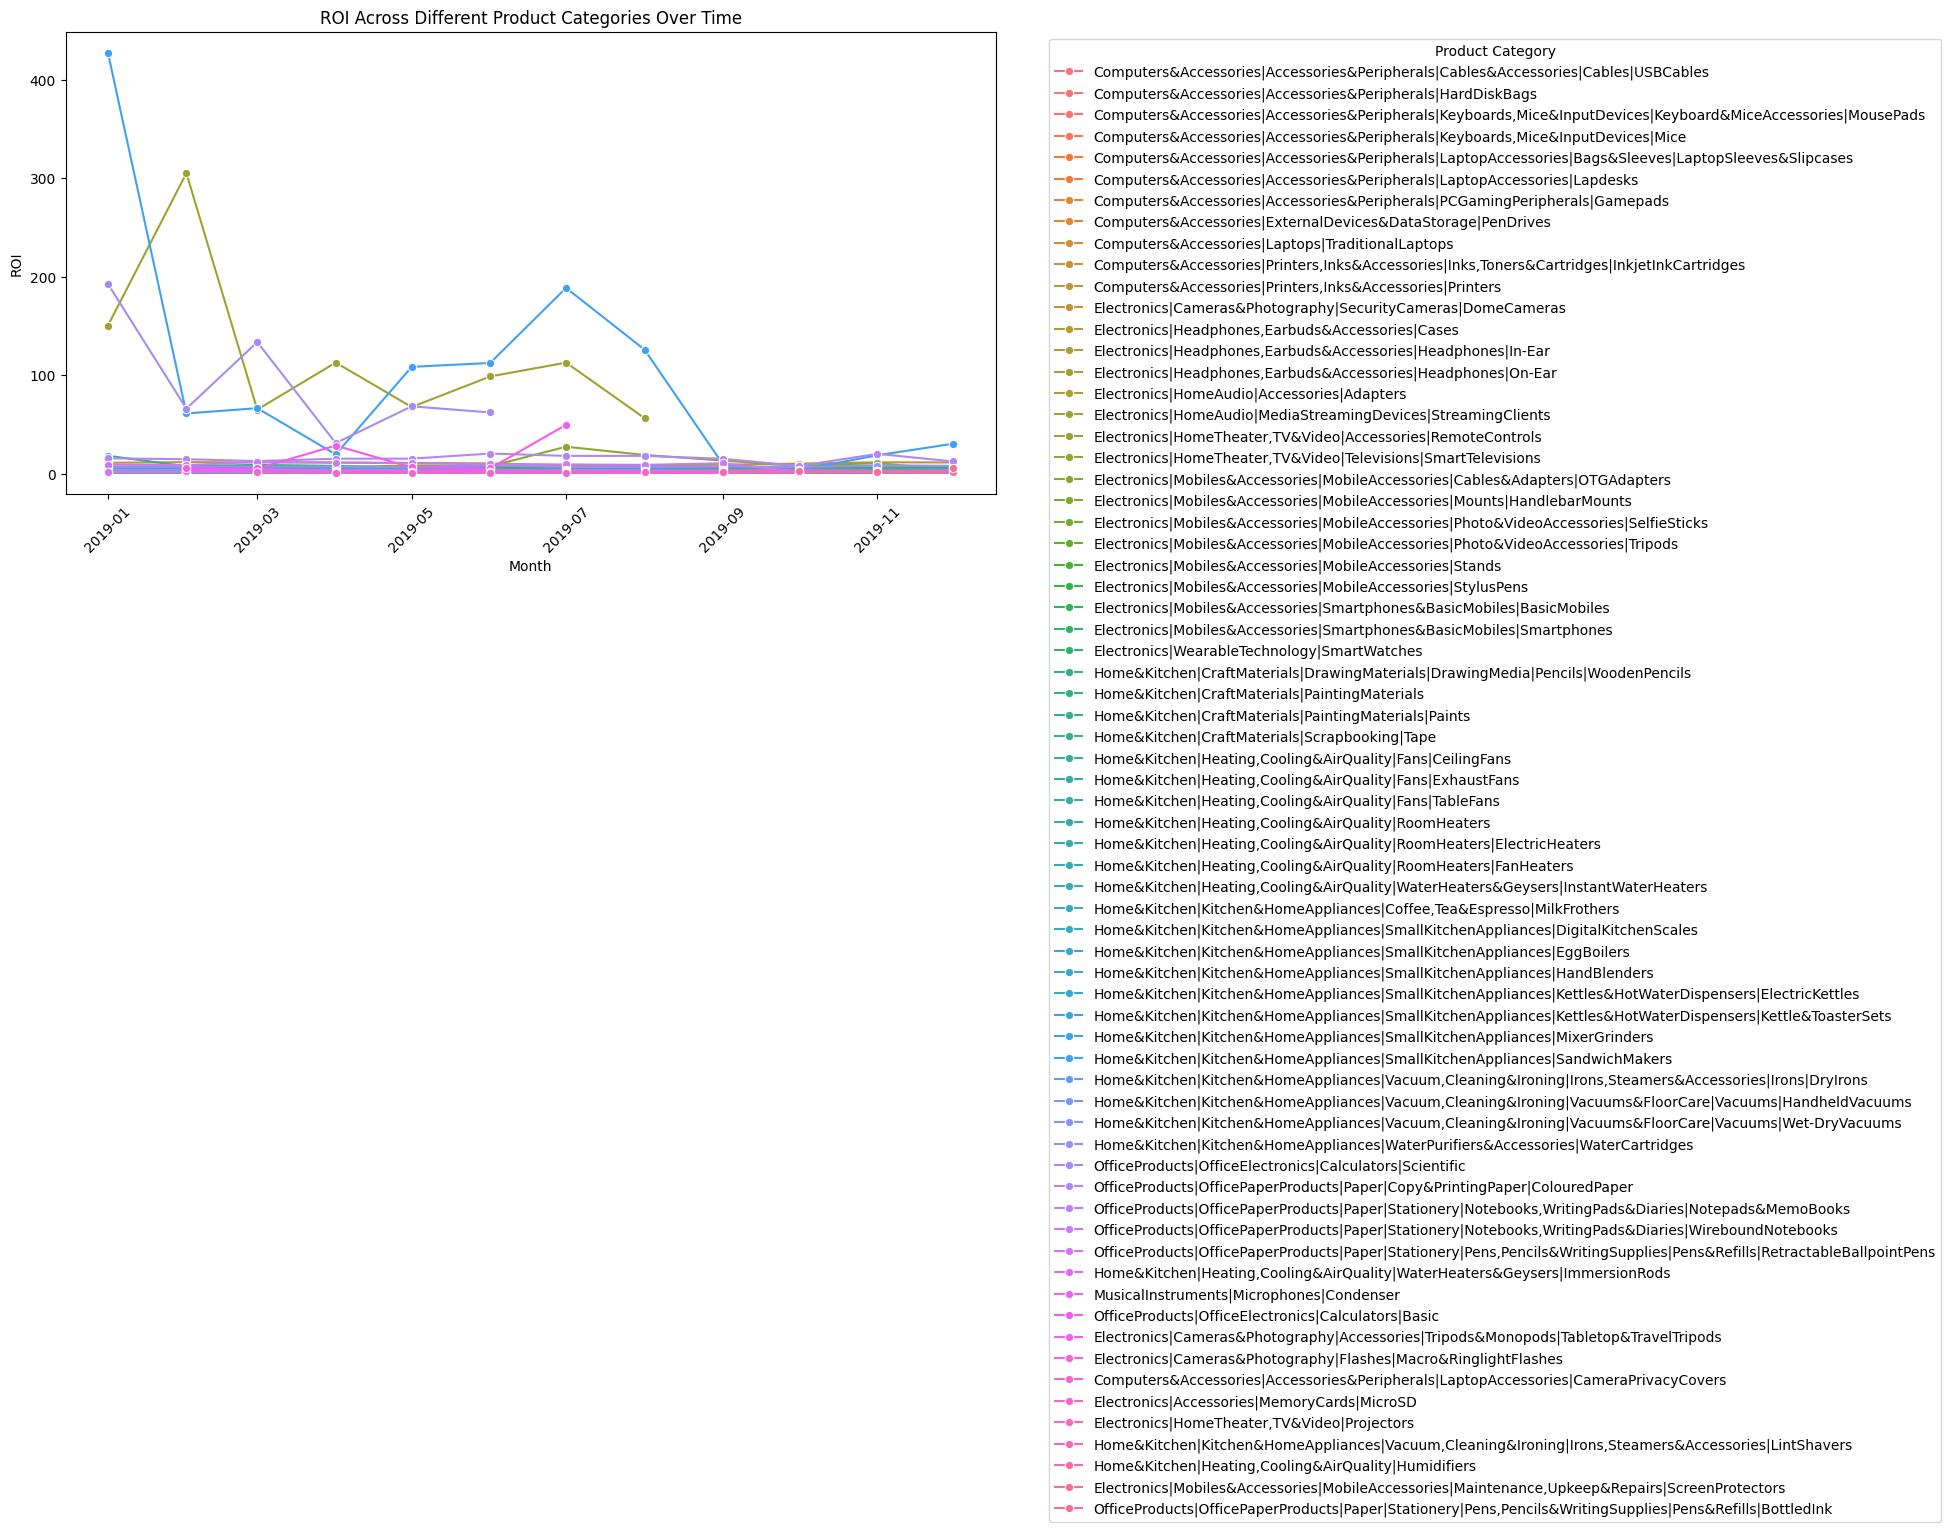

In [9]:
sales_by_month_category['ROI'] = pd.to_numeric(sales_by_month_category['ROI'], errors='coerce')
sales_by_month_category = sales_by_month_category.dropna(subset=['ROI'])

if not pd.api.types.is_datetime64_any_dtype(sales_by_month_category['date']):
    sales_by_month_category['date'] = pd.to_datetime(sales_by_month_category['date'].astype(str), errors='coerce')

# Visualize ROI across months and categories again
plt.figure(figsize=(12, 6))
sns.lineplot(data=sales_by_month_category, x='date', y='ROI', hue='category', marker='o')

plt.title('ROI Across Different Product Categories Over Time')
plt.xlabel('Month')
plt.ylabel('ROI')
plt.xticks(rotation=45)

plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


### Analysis of ROI Across Different Coupon Status

/var/folders/cr/yg8f_zlx5w1_6mw1x0jdd6mr0000gn/T/ipykernel_89273/2083592087.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coupon_roi, x='Coupon_Status', y='ROI', palette='coolwarm')


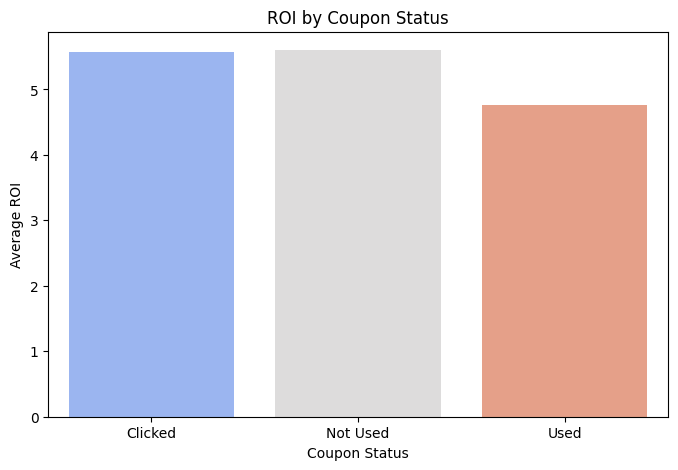

In [10]:
# Group by Coupon Status to compare ROI for users who used coupons vs. not
coupon_roi = sales_data.groupby('Coupon_Status').agg({
    'revenue': 'sum',
    'discount_cost': 'sum',
    'ROI': 'mean'
}).reset_index()

# Visualize ROI by coupon status
plt.figure(figsize=(8, 5))
sns.barplot(data=coupon_roi, x='Coupon_Status', y='ROI', palette='coolwarm')
plt.title('ROI by Coupon Status')
plt.ylabel('Average ROI')
plt.xlabel('Coupon Status')
plt.show()

### Analysis of ROI Across Different Marketing Channels

In [11]:
#Generating Synthetic Data

# List of marketing channels
marketing_channels = [
    'Social Media - Facebook', 'Social Media - Instagram', 'Email Campaign',
    'SEM - Google Ads', 'SEO', 'Influencer Marketing', 'Affiliate Marketing',
    'Display Ads - Banners', 'Referral Program', 'Content Marketing - Blog'
]

# Generate synthetic marketing channel data for each transaction
np.random.seed(42)
sales_data['marketing_channel'] = np.random.choice(marketing_channels, size=len(sales_data))

# (Assumption) Simulate channel effectiveness with a multiplier
# Some channels might be more effective, resulting in higher ROI on average
channel_effectiveness = {
    'Social Media - Facebook': 1.1,
    'Social Media - Instagram': 1.2,
    'Email Campaign': 1.3,
    'SEM - Google Ads': 0.9,
    'SEO': 1.5,
    'Influencer Marketing': 1.4,
    'Affiliate Marketing': 0.8,
    'Display Ads - Banners': 0.7,
    'Referral Program': 1.6,
    'Content Marketing - Blog': 1.3
}

# Apply effectiveness multiplier to the ROI for each channel
sales_data['ROI_adjusted'] = sales_data.apply(
    lambda row: row['ROI'] * channel_effectiveness[row['marketing_channel']], axis=1
)

# Preview data
print(sales_data[['product_name', 'Quantity', 'revenue', 'discount_cost', 'marketing_channel', 'ROI', 'ROI_adjusted']].head())

                                        product_name  Quantity  revenue  \
0  Hindware Atlantic Compacto 3 Litre Instant wat...         1    55.08   
1  Hindware Atlantic Compacto 3 Litre Instant wat...         1    55.08   
2  Hindware Atlantic Compacto 3 Litre Instant wat...         1    55.08   
3  Hindware Atlantic Compacto 3 Litre Instant wat...         1    55.08   
4  Hindware Atlantic Compacto 3 Litre Instant wat...         1    55.08   

   discount_cost      marketing_channel       ROI  ROI_adjusted  
0          26.29    Affiliate Marketing  2.018322      1.614657  
1          26.29       SEM - Google Ads  2.018322      1.816490  
2          26.29  Display Ads - Banners  2.018322      1.412825  
3          26.29                    SEO  2.018322      3.027483  
4          26.29    Affiliate Marketing  2.018322      1.614657  


/var/folders/cr/yg8f_zlx5w1_6mw1x0jdd6mr0000gn/T/ipykernel_89273/2636477128.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=channel_roi, x='marketing_channel', y='ROI_adjusted', palette='coolwarm')


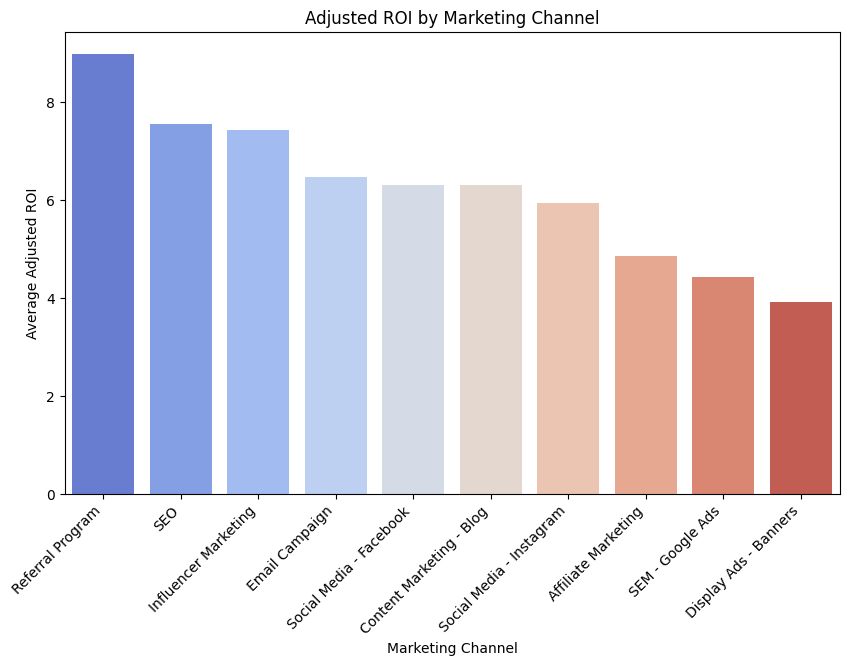

In [12]:
# Group by marketing channel to analyze ROI
channel_roi = sales_data.groupby('marketing_channel').agg({
    'revenue': 'sum',
    'discount_cost': 'sum',
    'ROI_adjusted': 'mean'
}).reset_index()

# Sort by adjusted ROI for better visualization
channel_roi = channel_roi.sort_values(by='ROI_adjusted', ascending=False)

# Visualize ROI by marketing channel
plt.figure(figsize=(10, 6))
sns.barplot(data=channel_roi, x='marketing_channel', y='ROI_adjusted', palette='coolwarm')
plt.title('Adjusted ROI by Marketing Channel')
plt.ylabel('Average Adjusted ROI')
plt.xlabel('Marketing Channel')
plt.xticks(rotation=45, ha='right')
plt.show()

### Analysis of Seasonality Effects on ROI across Different Marketing Channels

In [13]:
#Analysing Seasonality Effects

# (Assumption) Seasonality multipliers when Amazon changes their marketing strategies according to different occasions
seasonality_multipliers = {
    'Holiday': {
        'Social Media - Facebook': 1.3,
        'Social Media - Instagram': 1.4,
        'Email Campaign': 1.2,
        'Display Ads - Banners': 1.5,
        'Affiliate Marketing': 1.1
    },
    'Back-to-School': {
        'SEO': 1.4,
        'Content Marketing - Blog': 1.3,
        'Affiliate Marketing': 1.2,
        'SEM - Google Ads': 1.1,
    },
    'Summer Sales': {
        'Email Campaign': 1.5,
        'Social Media - Facebook': 1.3,
        'Referral Program': 1.4,
    }
}

seasonality_periods = {
    'Holiday': ['11', '12'],
    'Back-to-School': ['08', '09'], 
    'Summer Sales': ['06', '07'],     
}

# Apply seasonality adjustments based on the month
sales_data['month'] = sales_data['date'].dt.strftime('%m')
def apply_seasonality(row):
    for season, months in seasonality_periods.items():
        if row['month'] in months:
            if row['marketing_channel'] in seasonality_multipliers[season]:
                multiplier = seasonality_multipliers[season][row['marketing_channel']]
                return row['ROI_adjusted'] * multiplier
    return row['ROI_adjusted']

# Create a new column for seasonally adjusted ROI
sales_data['ROI_seasonal_adjusted'] = sales_data.apply(apply_seasonality, axis=1)

print(sales_data[['date', 'product_name', 'marketing_channel', 'ROI', 'ROI_adjusted', 'ROI_seasonal_adjusted']].head())

        date                                       product_name  \
0 2019-01-01  Hindware Atlantic Compacto 3 Litre Instant wat...   
1 2019-01-01  Hindware Atlantic Compacto 3 Litre Instant wat...   
2 2019-01-01  Hindware Atlantic Compacto 3 Litre Instant wat...   
3 2019-01-01  Hindware Atlantic Compacto 3 Litre Instant wat...   
4 2019-01-01  Hindware Atlantic Compacto 3 Litre Instant wat...   

       marketing_channel       ROI  ROI_adjusted  ROI_seasonal_adjusted  
0    Affiliate Marketing  2.018322      1.614657               1.614657  
1       SEM - Google Ads  2.018322      1.816490               1.816490  
2  Display Ads - Banners  2.018322      1.412825               1.412825  
3                    SEO  2.018322      3.027483               3.027483  
4    Affiliate Marketing  2.018322      1.614657               1.614657  


In [14]:
sales_data['year'] = sales_data['date'].dt.year
sales_data['month'] = sales_data['date'].dt.month
seasonal_roi = sales_data.groupby(['marketing_channel', 'year', 'month']).agg({
    'ROI_seasonal_adjusted': 'mean'
}).reset_index()
seasonal_roi['year_month'] = pd.to_datetime(seasonal_roi[['year', 'month']].assign(day=1))
seasonal_roi.head()

,marketing_channel,year,month,ROI_seasonal_adjusted,year_month
0,Affiliate Marketing,2019,1,3.459437,2019-01-01
1,Affiliate Marketing,2019,2,4.372303,2019-02-01
2,Affiliate Marketing,2019,3,3.740078,2019-03-01
3,Affiliate Marketing,2019,4,3.648247,2019-04-01
4,Affiliate Marketing,2019,5,3.478702,2019-05-01


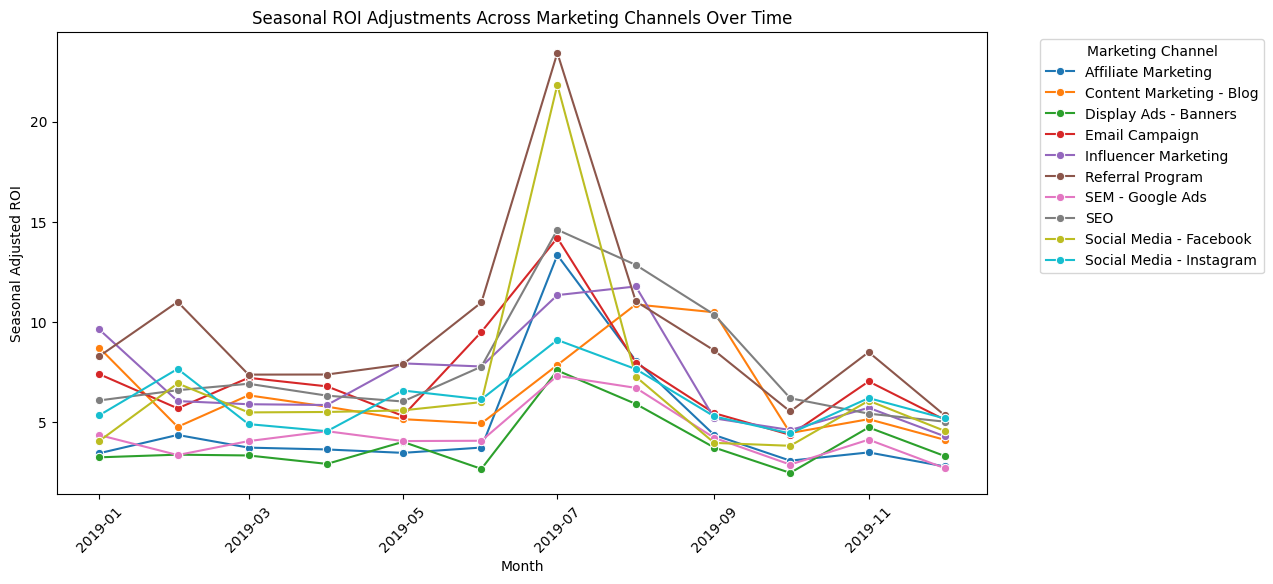

In [15]:
# Visualize seasonal effects on marketing channels
plt.figure(figsize=(12, 6))
sns.lineplot(data=seasonal_roi, x='year_month', y='ROI_seasonal_adjusted', hue='marketing_channel', marker='o')
plt.title('Seasonal ROI Adjustments Across Marketing Channels Over Time')
plt.xlabel('Month')
plt.ylabel('Seasonal Adjusted ROI')
plt.xticks(rotation=45)
plt.legend(title='Marketing Channel', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Observation: 
1. The chart highlights a significant mid-year spike in ROI for most marketing channels, with Referral Program and Social Media - Facebook being the top performers. This indicates that these channels might be leveraged more heavily during peak promotion periods like summer.
2. Referral Programs and Social Media - Facebook consistently outperform other channels, particularly during the peak months. This suggests that referral-driven marketing and Facebook campaigns may be particularly well-suited for seasonal promotions. SEO, Content Marketing - Blog, and Email Campaign perform steadily, but without the dramatic peaks seen in some of the other channels.
3. The downward trend after July suggests a potential reduction in marketing effectiveness later in the year, signaling the need for optimized strategies during that time. The early part of the year, while stable, may also benefit from targeted campaigns to boost ROI. This analysis can help in planning marketing strategies, optimizing campaign timing, and selecting the most effective channels to maximize ROI throughout the year.

### Analysis of ROI across Different Marketing Channel using Customer Segmentation

In [16]:
# Customer segmentation using K-means clustering
clustering_data = sales_data[['ROI_seasonal_adjusted', 'marketing_channel', 'Quantity', 'Coupon_Status']]
encoder = OneHotEncoder()
encoded_channels = pd.DataFrame(encoder.fit_transform(clustering_data[['marketing_channel', 'Coupon_Status']]).toarray(), columns=encoder.get_feature_names_out())
clustering_data = pd.concat([clustering_data[['ROI_seasonal_adjusted', 'Quantity']], encoded_channels], axis=1)

# Data cleaning and scaling
clustering_data.fillna(0, inplace=True)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_data)

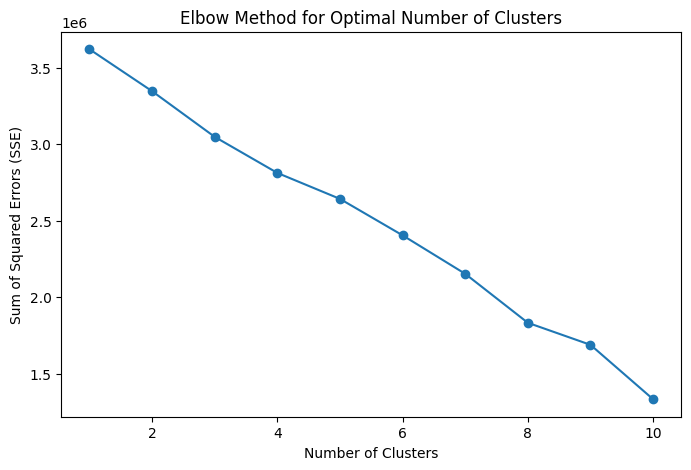

In [17]:
# Finding the optimal number of clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.show()

Conclusion:
The "elbow" of the curve is where the rate of decrease in SSE slows down significantly. This point suggests the optimal number of clusters. In this case, the elbow appears to occur at 3 or 4 clusters, as the SSE decreases more gradually after this point. Choosing 3 or 4 clusters would balance between having a good clustering structure (lower SSE) and avoiding overfitting by adding too many clusters.

In [18]:
# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=1)  # Using 3 clusters as an example
clustering_data['cluster'] = kmeans.fit_predict(scaled_features)
sales_data['customer_segment'] = clustering_data['cluster']

print(sales_data[['customer_segment', 'ROI_seasonal_adjusted', 'marketing_channel', 'Quantity', 'Coupon_Status']].head())

   customer_segment  ROI_seasonal_adjusted      marketing_channel  Quantity  \
0                 2               1.614657    Affiliate Marketing         1   
1                 2               1.816490       SEM - Google Ads         1   
2                 2               1.412825  Display Ads - Banners         1   
3                 2               3.027483                    SEO         1   
4                 2               1.614657    Affiliate Marketing         1   

  Coupon_Status  
0          Used  
1          Used  
2          Used  
3          Used  
4          Used  


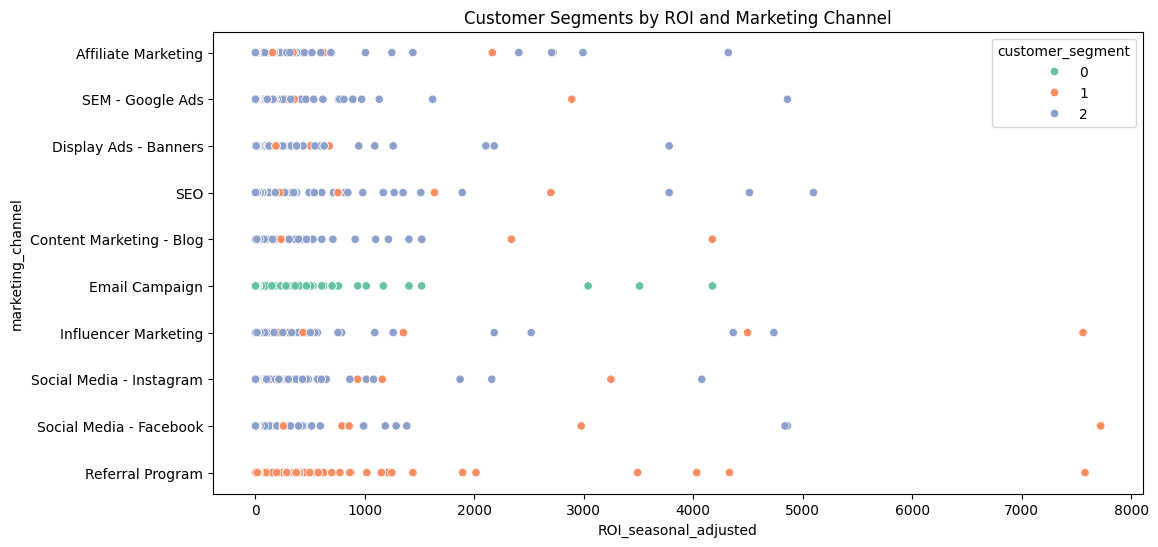

In [19]:
# Plot the clusters based on ROI and Marketing Channel
plt.figure(figsize=(12, 6))
sns.scatterplot(data=sales_data, x='ROI_seasonal_adjusted', y='marketing_channel', hue='customer_segment', palette='Set2')
plt.title('Customer Segments by ROI and Marketing Channel')
plt.show()

Observations:
1. Email Campaigns Perform Consistently Well: Across all three customer segments (0, 1, 2), email campaigns seem to result in fairly consistent ROI values, mostly clustering around similar ranges. This might imply that email campaigns are an effective channel for reaching a diverse customer base.
2. Affiliate Marketing and Referral Programs Are High ROI for Specific Segments: For some customer segments, especially customer segment 2, affiliate marketing and referral programs show higher ROI outliers. These marketing channels may be more effective for targeting specific segments rather than all customers.
3. Broad Distribution for Influencer and Social Media Marketing: Influencer Marketing and Social Media channels (Instagram and Facebook) show a wider spread of ROI values across different customer segments, suggesting that these channels might have inconsistent performance depending on the audience. These marketing efforts may work very well for some customers but less so for others.

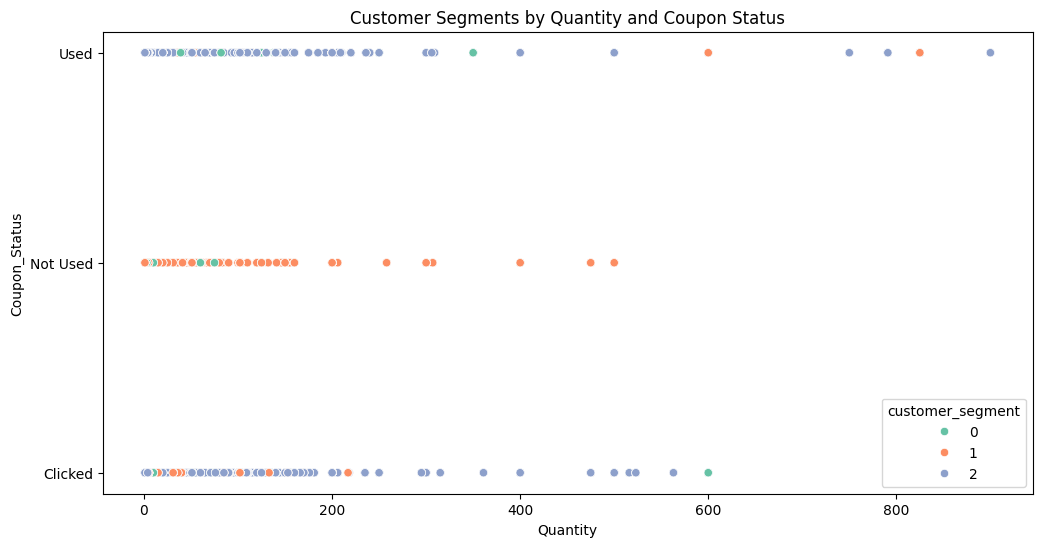

In [20]:
# Plot the clusters based on Quantity and Coupon Status
plt.figure(figsize=(12, 6))
sns.scatterplot(data=sales_data, x='Quantity', y='Coupon_Status', hue='customer_segment', palette='Set2')
plt.title('Customer Segments by Quantity and Coupon Status')
plt.show()

Observations:
1. Higher Quantities for "Used" Coupons in Segment 2: The customer segment 2 appears to be associated with higher quantities of purchases when the coupon was "Used." This indicates that segment 2 tends to take more advantage of coupons, leading to larger transactions.
2. "Not Used" Coupons Cluster: When coupons were "Not Used," there is a clear cluster of smaller quantities across all segments. This suggests that users not engaging with coupons generally purchase in smaller quantities. Segment 1 (orange) has the highest density here, implying they may not rely on or be incentivized by coupons as much as others.
3. Coupon "Clicked" Behavior: When coupons were "Clicked" but not used, there is more spread across customer segments and quantities. However, the quantities remain relatively lower for "Clicked" compared to "Used," implying that clicking alone may not drive higher purchase volumes.

## 2. Analyze the impact of various promotional campaigns on sales.

### Analysis of the Impact of Different Promotional Campaigns on Sales

In [21]:
merged_data = pd.merge(online_sales, products, on='product_id', how='left')
merged_data = pd.merge(merged_data, discount_coupon, left_on='Coupon_Code', right_on='Coupon_Code', how='left')

print(merged_data.head())

   user_id  transaction_id        date  product_id  Quantity  \
0    17850           16679  2019-01-01  B09DL9978Y         1   
1    17850           16679  2019-01-01  B09DL9978Y         1   
2    17850           16679  2019-01-01  B09DL9978Y         1   
3    17850           16679  2019-01-01  B09DL9978Y         1   
4    17850           16680  2019-01-01  B09DL9978Y         1   

   Delivery_Charges Coupon_Status Coupon_Code  Discount_pct_x  \
0               6.5          Used      ELEC10             0.1   
1               6.5          Used      ELEC10             0.1   
2               6.5          Used      ELEC10             0.1   
3               6.5          Used      ELEC10             0.1   
4               6.5          Used      ELEC10             0.1   

                                        product_name  \
0  Hindware Atlantic Compacto 3 Litre Instant wat...   
1  Hindware Atlantic Compacto 3 Litre Instant wat...   
2  Hindware Atlantic Compacto 3 Litre Instant wat...   


In [22]:
promo_data = merged_data[merged_data['Coupon_Status'] == 'Used']

print(promo_data.head())

   user_id  transaction_id        date  product_id  Quantity  \
0    17850           16679  2019-01-01  B09DL9978Y         1   
1    17850           16679  2019-01-01  B09DL9978Y         1   
2    17850           16679  2019-01-01  B09DL9978Y         1   
3    17850           16679  2019-01-01  B09DL9978Y         1   
4    17850           16680  2019-01-01  B09DL9978Y         1   

   Delivery_Charges Coupon_Status Coupon_Code  Discount_pct_x  \
0               6.5          Used      ELEC10             0.1   
1               6.5          Used      ELEC10             0.1   
2               6.5          Used      ELEC10             0.1   
3               6.5          Used      ELEC10             0.1   
4               6.5          Used      ELEC10             0.1   

                                        product_name  \
0  Hindware Atlantic Compacto 3 Litre Instant wat...   
1  Hindware Atlantic Compacto 3 Litre Instant wat...   
2  Hindware Atlantic Compacto 3 Litre Instant wat...   


In [23]:
# Calculations
promo_data['total_revenue'] = promo_data['Quantity'] * promo_data['discounted_price']

# Group by Coupon_Code to see the impact of each promotion
promotion_impact = promo_data.groupby('Coupon_Code').agg({
    'Quantity': 'sum',
    'total_revenue': 'sum',
    'transaction_id': 'count' 
}).reset_index()

promotion_impact.columns = ['Coupon_Code', 'Total_Quantity_Sold', 'Total_Revenue', 'Transaction_Count']
print(promotion_impact.head())

  Coupon_Code  Total_Quantity_Sold  Total_Revenue  Transaction_Count
0       ACC10                 1008        5432.56                148
1       ACC20                 1620        7575.52                220
2       ACC30                  764        3463.72                148
3       AIO10                 5984      256199.72                944
4       AIO20                 5132      152183.52                852


/var/folders/cr/yg8f_zlx5w1_6mw1x0jdd6mr0000gn/T/ipykernel_89273/1588000226.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  promo_data['total_revenue'] = promo_data['Quantity'] * promo_data['discounted_price']


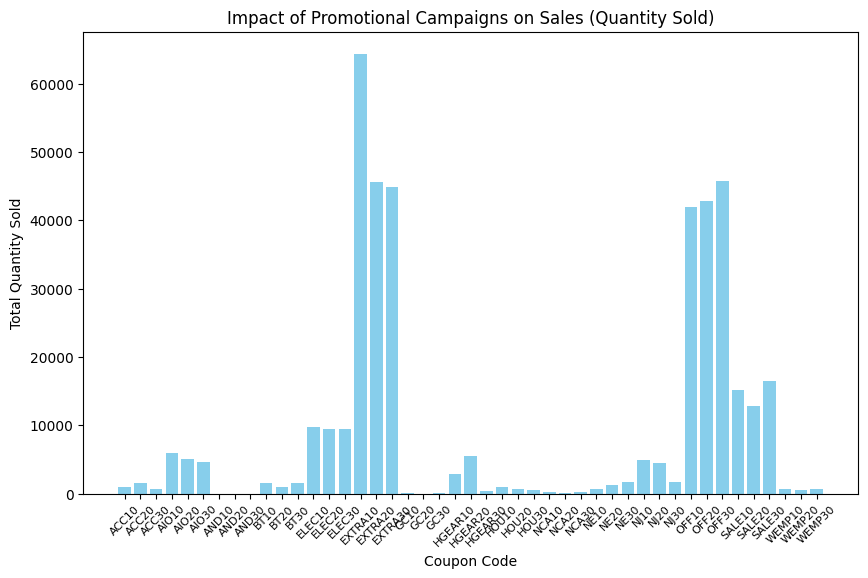

In [24]:
# Bar plot for total quantity sold by each promotion
plt.figure(figsize=(10, 6))
plt.bar(promotion_impact['Coupon_Code'], promotion_impact['Total_Quantity_Sold'], color='skyblue')
plt.xlabel('Coupon Code')
plt.ylabel('Total Quantity Sold')
plt.title('Impact of Promotional Campaigns on Sales (Quantity Sold)')
plt.xticks(rotation=45, fontsize=8) 
plt.show()

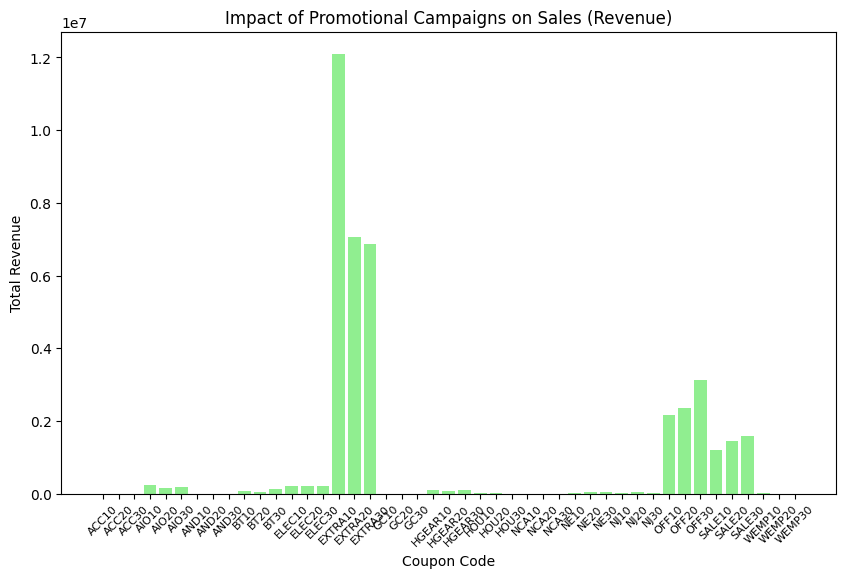

In [25]:
# Bar plot for total revenue by each coupon code
plt.figure(figsize=(10, 6))
plt.bar(promotion_impact['Coupon_Code'], promotion_impact['Total_Revenue'], color='lightgreen')
plt.xlabel('Coupon Code')
plt.ylabel('Total Revenue')
plt.title('Impact of Promotional Campaigns on Sales (Revenue)')
plt.xticks(rotation=45, fontsize=8) 
plt.show()

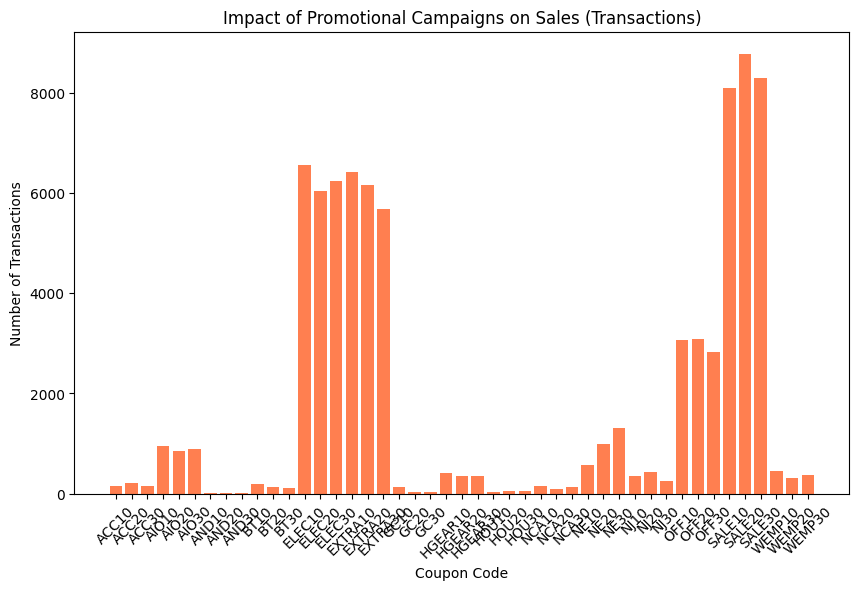

In [26]:
# Bar plot for number of transactions by each promotion
plt.figure(figsize=(10, 6))
plt.bar(promotion_impact['Coupon_Code'], promotion_impact['Transaction_Count'], color='coral')
plt.xlabel('Coupon Code')
plt.ylabel('Number of Transactions')
plt.title('Impact of Promotional Campaigns on Sales (Transactions)')
plt.xticks(rotation=45, fontsize=10) 
plt.show()

### Analysis of the Usage of Promotional Campaigns on ROI and Revenue

In [27]:
# Calculations
merged_data = merged_data.drop('Discount_pct_y', axis=1)
merged_data['revenue'] = merged_data['Quantity'] * merged_data['discounted_price']
merged_data['discount_cost'] = merged_data['Quantity'] * merged_data['actual_price'] * merged_data['Discount_pct_x']
merged_data['ROI'] = merged_data['revenue'] / (merged_data['discount_cost'] + 1)

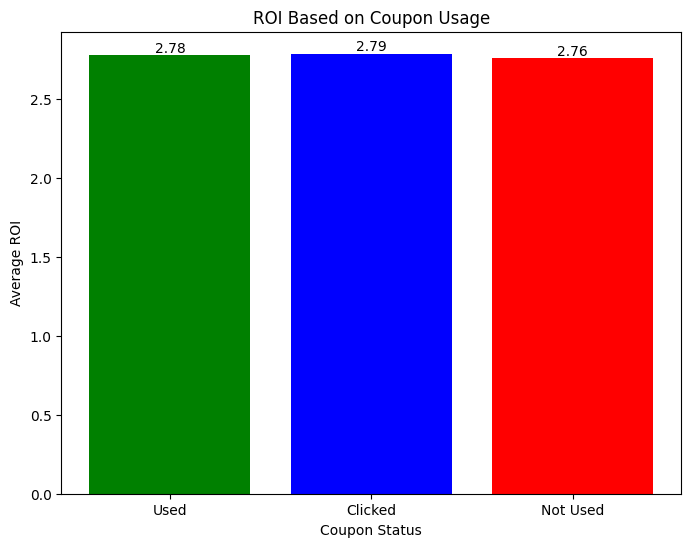

In [28]:
coupon_used = merged_data[merged_data['Coupon_Status'] == 'Used']
coupon_clicked = merged_data[merged_data['Coupon_Status'] == 'Clicked']
coupon_not_used = merged_data[merged_data['Coupon_Status'] == 'Not Used']

roi_used = coupon_used['ROI'].mean()
roi_clicked = coupon_clicked['ROI'].mean()
roi_not_used = coupon_not_used['ROI'].mean()

roi_values = [roi_used, roi_clicked, roi_not_used]
statuses = ['Used', 'Clicked', 'Not Used']

plt.figure(figsize=(8, 6))
bars = plt.bar(statuses, roi_values, color=['green', 'blue', 'red'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.xlabel('Coupon Status')
plt.ylabel('Average ROI')
plt.title('ROI Based on Coupon Usage')
plt.show()


Observation: The similarity in ROI values across different coupon statuses indicates that coupon engagement (used, clicked, or not used) doesn't drastically impact the company's return on investment. This suggests that coupon-driven promotions are not a financial strain and are likely serving as an effective tool to maintain or enhance customer engagement without reducing profitability. This could be seen as a positive outcome, indicating that the company's promotional strategy is well-balanced and that customers are making valuable transactions whether or not they use coupons.

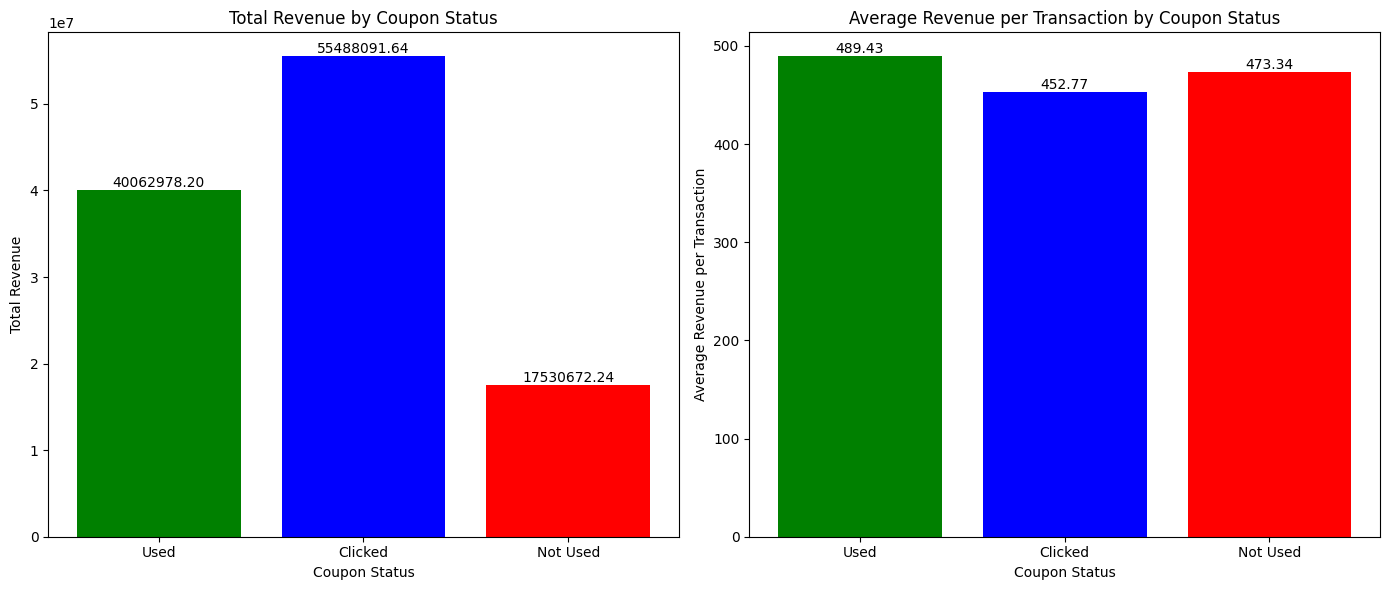

In [29]:
total_revenue_used = coupon_used['revenue'].sum()
total_revenue_clicked = coupon_clicked['revenue'].sum()
total_revenue_not_used = coupon_not_used['revenue'].sum()

avg_revenue_used = coupon_used['revenue'].mean()
avg_revenue_clicked = coupon_clicked['revenue'].mean()
avg_revenue_not_used = coupon_not_used['revenue'].mean()

total_revenue_values = [total_revenue_used, total_revenue_clicked, total_revenue_not_used]
avg_revenue_values = [avg_revenue_used, avg_revenue_clicked, avg_revenue_not_used]
statuses = ['Used', 'Clicked', 'Not Used']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Total Revenue
bars1 = ax1.bar(statuses, total_revenue_values, color=['green', 'blue', 'red'])
ax1.set_xlabel('Coupon Status')
ax1.set_ylabel('Total Revenue')
ax1.set_title('Total Revenue by Coupon Status')
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

# Plot for Average Revenue per Transaction
bars2 = ax2.bar(statuses, avg_revenue_values, color=['green', 'blue', 'red'])
ax2.set_xlabel('Coupon Status')
ax2.set_ylabel('Average Revenue per Transaction')
ax2.set_title('Average Revenue per Transaction by Coupon Status')
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Observation:
1. The much lower revenue from "Not Used" coupons suggests that promotional campaigns is essential for driving higher revenue.
2. While coupons seem to drive higher total revenue, the average transaction value is relatively close across all categories, with Used coupons yielding the highest value. This indicates that customers who do not use coupons still make significant purchases. Those who do not engage with the coupons are not necessarily spending much less per transaction.

### Analysis of Seasonality Usage of Coupons on Revenue

In [30]:
merged_data['date'] = pd.to_datetime(merged_data['date'])
merged_data['Month'] = merged_data['date'].dt.month

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

merged_data['Season'] = merged_data['Month'].apply(get_season)

In [31]:
monthly_revenue = merged_data.groupby(['Month', 'Coupon_Status']).agg({
    'revenue': 'sum',
    'transaction_id': 'count'
}).reset_index()

monthly_revenue.columns = ['Month', 'Coupon_Status', 'Total_Revenue', 'Transaction_Count']

seasonal_revenue = merged_data.groupby(['Season', 'Coupon_Status']).agg({
    'revenue': 'sum',
    'transaction_id': 'count'
}).reset_index()

seasonal_revenue.columns = ['Season', 'Coupon_Status', 'Total_Revenue', 'Transaction_Count']

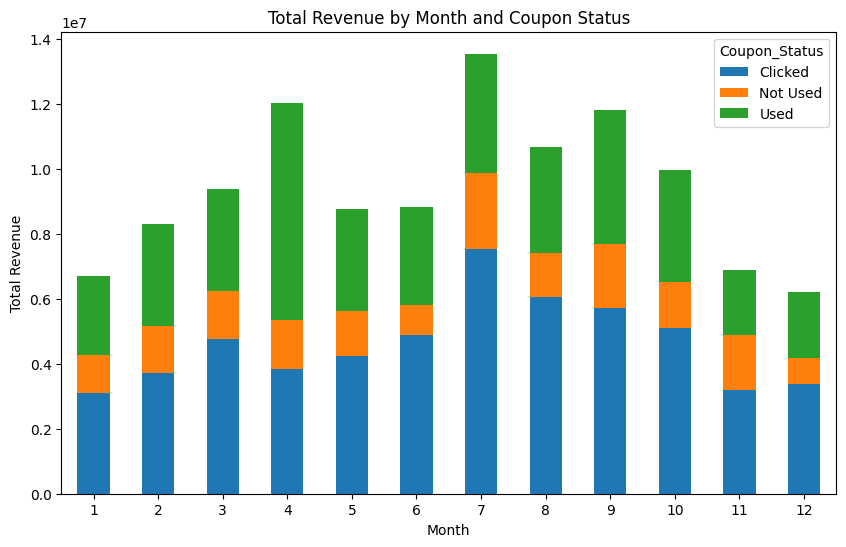

In [32]:
monthly_pivot = monthly_revenue.pivot(index='Month', columns='Coupon_Status', values='Total_Revenue')

monthly_pivot.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.title('Total Revenue by Month and Coupon Status')
plt.xticks(rotation=0)
plt.show()

Observation: 
1. Across most months, the Used coupon status contributes the largest portion of total revenue. This shows that coupons, when redeemed, are driving substantial revenue, particularly in months like June and July. Even in other months, the "Used" category consistently accounts for a significant share of the total revenue, suggesting that active coupon usage is a powerful driver of sales.
2. "Clicked" Coupons Contribute a Significant Share: The Clicked coupon status also contributes meaningfully to revenue, especially in December and January, where it is proportionally higher compared to other months. Even when customers don't redeem coupons, clicking on them still leads to transactions and contributes to overall revenue.
3. The Not Used category consistently represents the smallest portion of total revenue, but its share is still non-negligible. This could indicate that some customers make purchases without taking advantage of available discounts or promotions. In months like October and November show a slightly higher share of revenue from the "Not Used" category, possibly due to different consumer behavior or marketing strategies during those months.
4. Seasonal Trends: The spike in revenue during June and July could reflect a seasonal peak, possibly related to summer sales or mid-year promotions.
The decline in revenue toward the end of the year (November and December) might indicate that typical promotional campaigns may not perform as strongly during these months, possibly due to market saturation or changes in customer spending patterns.

/var/folders/cr/yg8f_zlx5w1_6mw1x0jdd6mr0000gn/T/ipykernel_89273/1500824215.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seasonal_revenue = merged_data.groupby(['Season', 'Coupon_Status']).agg({


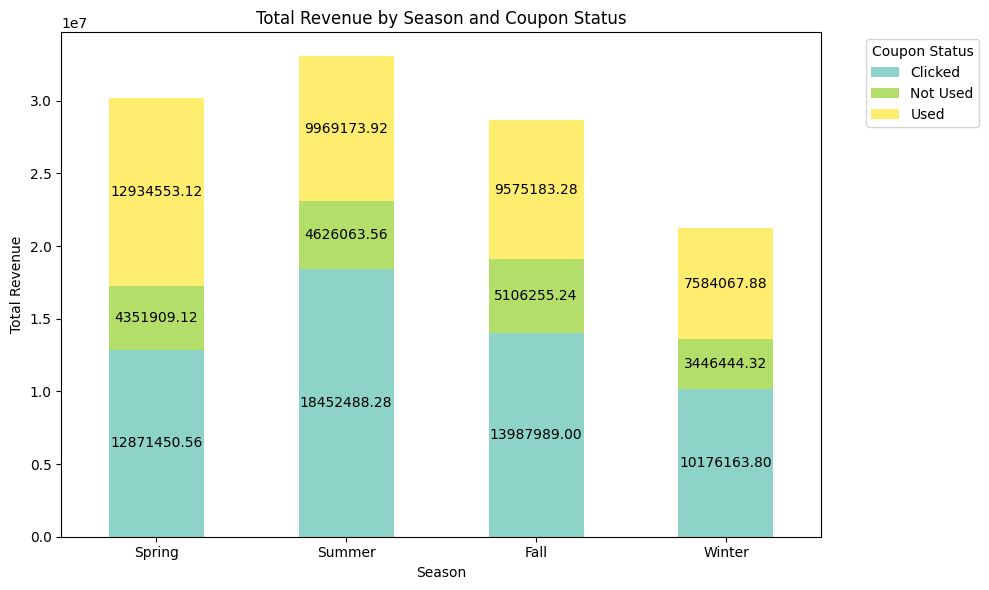

In [33]:
# Summarising data according to season
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
merged_data['Season'] = pd.Categorical(merged_data['Season'], categories=season_order, ordered=True)

seasonal_revenue = merged_data.groupby(['Season', 'Coupon_Status']).agg({
    'revenue': 'sum',
    'transaction_id': 'count'
}).reset_index()

# Plotting of total sales revenue according to season
seasonal_pivot = seasonal_revenue.pivot(index='Season', columns='Coupon_Status', values='revenue')

ax = seasonal_pivot.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set3')

for p in ax.patches:
    width = p.get_width()  
    height = p.get_height() 
    x = p.get_x() + width / 2  
    y = p.get_y() + height / 2  
    if height > 0:
        ax.text(x, y, f'{height:.2f}', ha='center', va='center')

plt.xlabel('Season')
plt.ylabel('Total Revenue')
plt.title('Total Revenue by Season and Coupon Status')
plt.xticks(rotation=0)
plt.legend(title='Coupon Status', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


Observation:
1. Highest Total Revenue in Summer: Summer generates the highest total revenue, significantly more than the other seasons. This indicates that promotions or seasonal demand in the summer may have a more substantial impact, possibly due to mid-year sales or summer holiday shopping. This is followed by Fall and Spring, while Winter has the lowest total revenue.
2. In all seasons, the "Clicked" coupons contribute the largest portion of revenue. This suggests that even when coupons aren't redeemed, customers who interact with the coupon still make purchases, leading to substantial revenue.
3. The "Used" coupons are more significant in Summer and Fall, indicating that coupon redemption is particularly effective during these times. In contrast, Winter sees the lowest revenue from used coupons, which could indicate a shift in consumer behavior (possibly a drop in the effectiveness of coupons during the holiday season).
4. Strong Performance of Spring and Summer: Both Summer and Fall show high revenues from Clicked and Used coupons, making these periods highly productive for promotional campaigns. This suggests these seasons are crucial for driving sales through coupon engagement.

### Analysis of Coupon Usage in Different User Demographics

In [34]:
# Summarising data according to gender and age
merged_data = pd.merge(merged_data, online_sales_users, on='user_id', how='left')

gender_revenue = merged_data.groupby(['gender', 'Coupon_Status']).agg({
    'revenue': 'sum',
    'transaction_id': 'count'  # To count the number of transactions
}).reset_index()

gender_revenue.columns = ['gender', 'Coupon_Status', 'Total_Revenue', 'Transaction_Count']

age_bins = [18, 25, 35, 45, 55, 65, 100]
age_labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
merged_data['Age_Group'] = pd.cut(merged_data['age'], bins=age_bins, labels=age_labels, right=False)

age_revenue = merged_data.groupby(['Age_Group', 'Coupon_Status']).agg({
    'revenue': 'sum',
    'transaction_id': 'count'  # To count the number of transactions
}).reset_index()

age_revenue.columns = ['Age_Group', 'Coupon_Status', 'Total_Revenue', 'Transaction_Count']

/var/folders/cr/yg8f_zlx5w1_6mw1x0jdd6mr0000gn/T/ipykernel_89273/1881574558.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_revenue = merged_data.groupby(['Age_Group', 'Coupon_Status']).agg({


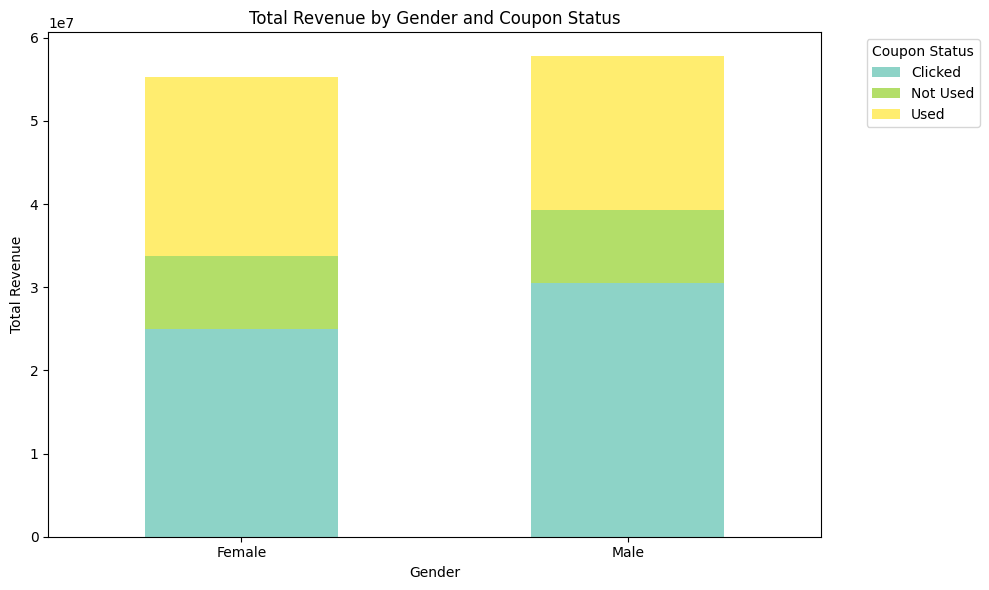

In [37]:
# Plotting of total revenue by gender and coupon status
gender_pivot = gender_revenue.pivot(index='gender', columns='Coupon_Status', values='Total_Revenue')

gender_pivot.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set3')

plt.xlabel('Gender')
plt.ylabel('Total Revenue')
plt.title('Total Revenue by Gender and Coupon Status')
plt.xticks(rotation=0)
plt.legend(title='Coupon Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Observation: 
1. Similar Total Revenue by Gender: The total revenue from female and male customers is very similar. This suggests that both genders are equally important to the overall sales performance.
2. "Clicked" Coupons Contribute the Most for Both Genders: For both females and males, the "Clicked" category contributes the largest portion of revenue. This shows that many customers engage with coupons by clicking them, even if they do not always use them, and this engagement translates into significant sales.
3. Coupon Usage ("Used" Coupons): The "Used" coupons also contribute a large portion of the total revenue, but the share is slightly smaller than the "Clicked" category. This indicates that while active coupon redemption drives revenue, engagement with coupons (clicking) is a more consistent driver across both genders.

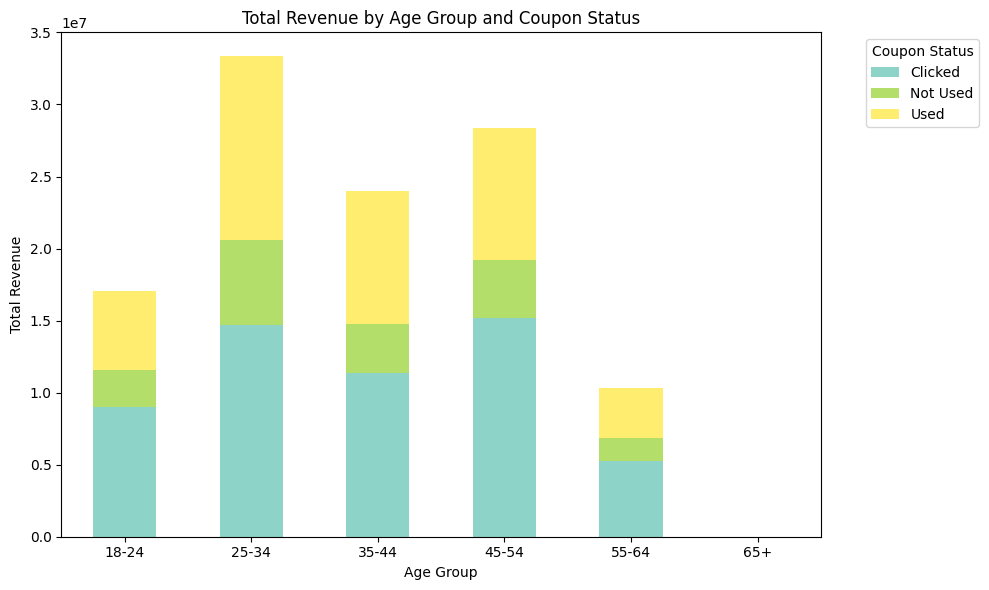

In [38]:
# Plotting of the total revenue by age group and coupon status
age_pivot = age_revenue.pivot(index='Age_Group', columns='Coupon_Status', values='Total_Revenue')

age_pivot.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set3')

plt.xlabel('Age Group')
plt.ylabel('Total Revenue')
plt.title('Total Revenue by Age Group and Coupon Status')
plt.xticks(rotation=0)
plt.legend(title='Coupon Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Observation:
1. Highest Revenue from 25-34 Age Group: The 25-34 age group generates the highest total revenue, followed by 35-44 and 45-54. This suggests that customers in the 25-44 range are the most valuable in terms of revenue generation, likely making them a key demographic for targeted marketing and promotions.
2. Coupon Engagement (Clicked and Used) Drives Revenue: In every age group, Clicked coupons make up a significant portion of the total revenue, indicating that coupon engagement (even without usage) is highly effective across all demographics. Used coupons contribute a large share of revenue in the higher-revenue age groups (25-54), indicating that customers who redeem coupons actively contribute to substantial revenue. However, younger customers (18-24) also generate revenue through coupon usage, though not as much as the older groups.
3. The age groups between 25-54 are the most valuable in terms of total revenue, and coupon engagement (whether clicking or using) is a major driver of sales for these age groups. Marketing strategies that focus on engaging these groups with targeted promotions and coupons are likely to yield high returns. Additionally, finding ways to better engage the 18-24 and 55+ age groups could lead to further revenue growth.

### Analysis of Different Amount of Discount on Sales

In [41]:
# Group by Discount_pct_x to calculate total revenue
discount_revenue = merged_data.groupby('Discount_pct_x').agg({
    'revenue': 'sum',
    'transaction_id': 'count' 
}).reset_index()

discount_revenue.columns = ['Discount_Percentage', 'Total_Revenue', 'Transaction_Count']

print(discount_revenue)


   Discount_Percentage  Total_Revenue  Transaction_Count
0                  0.1    42235868.92              81056
1                  0.2    34610641.32              81820
2                  0.3    36235231.84              78568


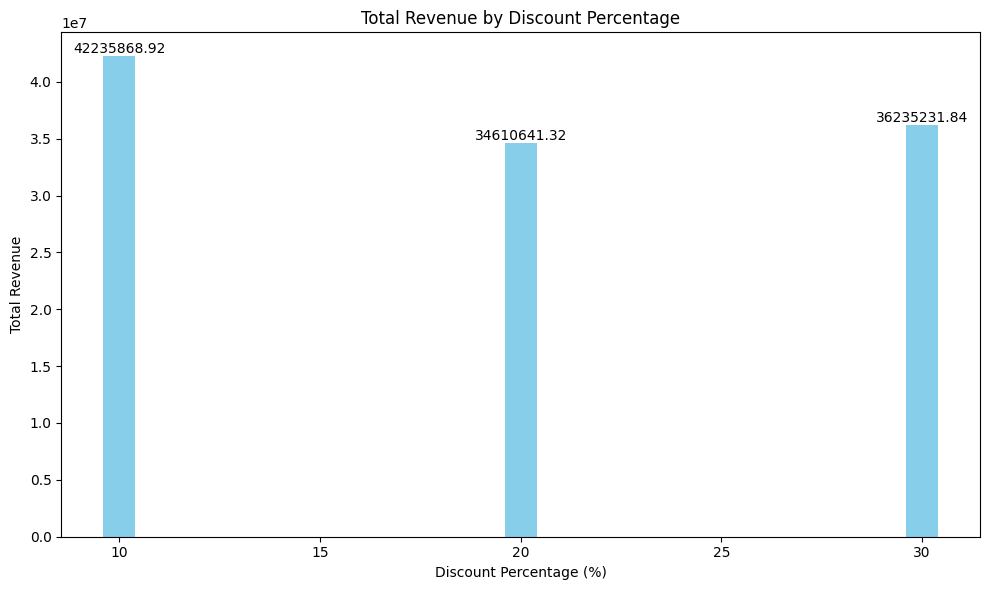

In [43]:
# Plotting of the total revenue by discount percentage
plt.figure(figsize=(10, 6))
bars = plt.bar(discount_revenue['Discount_Percentage'] * 100, discount_revenue['Total_Revenue'], color='skyblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.xlabel('Discount Percentage (%)')
plt.ylabel('Total Revenue')
plt.title('Total Revenue by Discount Percentage')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

Observation:
1. The 10% discount appears to be the most effective in driving sales and maximizing total revenue, likely due to its balance between customer appeal and profitability.
2. The 30% discount still generates significant revenue, suggesting that higher discounts work for specific customer segments or promotional strategies, but they may not be necessary for every campaign.
3. The 20% discount seems to be the least effective, potentially due to being stuck in a middle ground where it neither offers as much savings as 30% nor preserves as much profit margin as 10%.